In [7]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy

In [2]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [74]:
seq_fwd = [10, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [79]:
pos_emb = model.pos_embed(torch.tensor(seq_fwd), 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)
logits_mlp_pos.shape, preds_mlp_pos.shape

(torch.Size([10, 10, 10]), torch.Size([10, 10, 10]))

In [77]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [78]:
test = neuron_posembed_activations(pos_emb)
test.shape

torch.Size([10, 10, 512])

In [86]:
last_token_acts = test[0][-1].detach().cpu().numpy()

In [103]:
print(np.count_nonzero(last_token_acts))
print(np.count_nonzero(last_token_acts) / last_token_acts.size)

292
0.5703125


In [93]:
last_token_2d = last_token_acts[np.newaxis, :]
last_token_2d.shape

(1, 512)

Text(0.5, 0, 'Neuron')

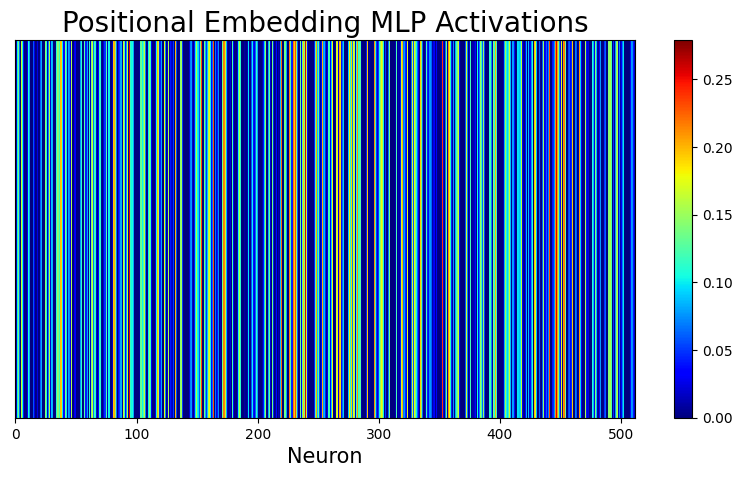

In [106]:
#plot last token acts imshow
plt.imshow(last_token_2d, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 10, 5
#title
plt.title("Positional Embedding MLP Activations", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)

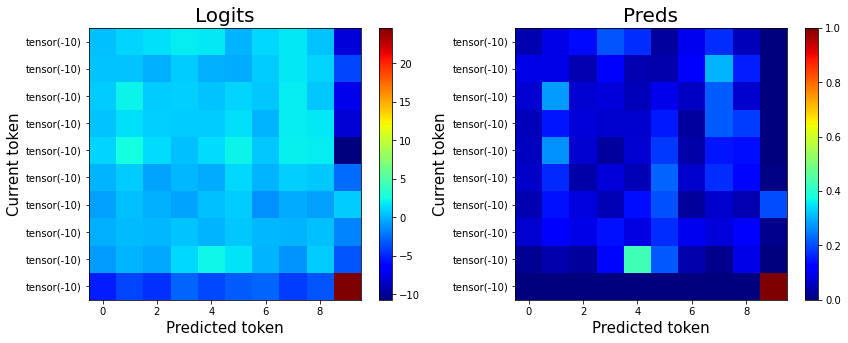

In [6]:
interpretability.plot_predictions(torch.tensor([-10]*10), logits_mlp_pos)

In [ ]:
test = interpretability.get_neuron_acts(model, seq_fwd)

In [ ]:
test.shape

torch.Size([10, 512])